In [1]:
!python --version

Python 3.9.10


In [2]:
import collections
import pathlib

import tensorflow as tf

from tensorflow.keras import layers
from tensorflow.keras import losses
from tensorflow.keras import utils
from tensorflow.keras.layers import TextVectorization

import tensorflow_datasets as tfds
import tensorflow_text as tf_text

ImportError: dlopen(/Users/rainyseason/miniforge3/envs/tf25/lib/python3.8/site-packages/tensorflow/python/_pywrap_tfe.so, 0x0002): Library not loaded: '@rpath/_pywrap_tensorflow_internal.so'
  Referenced from: '/Users/rainyseason/miniforge3/envs/tf25/lib/python3.8/site-packages/tensorflow/python/_pywrap_tfe.so'
  Reason: tried: '/Users/rainyseason/miniforge3/envs/tf25/lib/python3.8/site-packages/tensorflow/python/../../_solib_darwin_arm64/_U_S_Stensorflow_Spython_C_Upywrap_Utfe.so___Utensorflow/_pywrap_tensorflow_internal.so' (no such file), '/Users/rainyseason/miniforge3/envs/tf25/lib/python3.8/site-packages/tensorflow/python/../../_solib_darwin_arm64/_U_S_Stensorflow_Spython_C_Upywrap_Utensorflow_Uinternal_Umacos___Utensorflow_Spython/_pywrap_tensorflow_internal.so' (no such file), '/Users/rainyseason/miniforge3/envs/tf25/lib/python3.8/site-packages/tensorflow/python/_pywrap_tensorflow_internal.so' (no such file), '/Users/rainyseason/miniforge3/envs/tf25/lib/python3.8/site-packages/tensorflow/python/../_pywrap_tensorflow_internal.so' (no such file), '/Users/rainyseason/miniforge3/envs/tf25/lib/python3.8/site-packages/tensorflow/python/../../_solib_darwin_arm64/_U_S_Stensorflow_Spython_C_Upywrap_Utfe.so___Utensorflow/_pywrap_tensorflow_internal.so' (no such file), '/Users/rainyseason/miniforge3/envs/tf25/lib/python3.8/site-packages/tensorflow/python/../../_solib_darwin_arm64/_U_S_Stensorflow_Spython_C_Upywrap_Utensorflow_Uinternal_Umacos___Utensorflow_Spython/_pywrap_tensorflow_internal.so' (no such file), '/Users/rainyseason/miniforge3/envs/tf25/lib/python3.8/site-packages/tensorflow/python/_pywrap_tensorflow_internal.so' (no such file), '/Users/rainyseason/miniforge3/envs/tf25/lib/python3.8/site-packages/tensorflow/python/../_pywrap_tensorflow_internal.so' (no such file), '/Users/rainyseason/miniforge3/envs/tf25/bin/../lib/_pywrap_tensorflow_internal.so' (no such file), '/Users/rainyseason/miniforge3/envs/tf25/bin/../lib/_pywrap_tensorflow_internal.so' (no such file), '/usr/local/lib/_pywrap_tensorflow_internal.so' (no such file), '/usr/lib/_pywrap_tensorflow_internal.so' (no such file)

In [3]:
tf.__version__

'2.8.0'

## Example1 : Predict the tag for a Stack Overflow question

### Download and explore the dataset

In [4]:
data_url = 'https://storage.googleapis.com/download.tensorflow.org/data/stack_overflow_16k.tar.gz'

dataset_dir = utils.get_file(origin=data_url,
                            untar=True,
                            cache_dir='/Users/rainyseason/winston/Workspace/python/Pycharm Project/tf25/stack_overflow/cache',
                            cache_subdir='/Users/rainyseason/winston/Workspace/python/Pycharm Project/tf25/stack_overflow')

dataset_dir = pathlib.Path(dataset_dir).parent

In [5]:
list(dataset_dir.iterdir())

[PosixPath('/Users/rainyseason/winston/Workspace/python/Pycharm Project/tf25/stack_overflow/test'),
 PosixPath('/Users/rainyseason/winston/Workspace/python/Pycharm Project/tf25/stack_overflow/stack_overflow_16k.tar.gz'),
 PosixPath('/Users/rainyseason/winston/Workspace/python/Pycharm Project/tf25/stack_overflow/README.md'),
 PosixPath('/Users/rainyseason/winston/Workspace/python/Pycharm Project/tf25/stack_overflow/train')]

In [6]:
train_dir = dataset_dir / 'train'
list(train_dir.iterdir())

[PosixPath('/Users/rainyseason/winston/Workspace/python/Pycharm Project/tf25/stack_overflow/train/python'),
 PosixPath('/Users/rainyseason/winston/Workspace/python/Pycharm Project/tf25/stack_overflow/train/java'),
 PosixPath('/Users/rainyseason/winston/Workspace/python/Pycharm Project/tf25/stack_overflow/train/csharp'),
 PosixPath('/Users/rainyseason/winston/Workspace/python/Pycharm Project/tf25/stack_overflow/train/javascript')]

In [7]:
train_py_dir = train_dir / 'python'

In [8]:
list(train_py_dir.iterdir())[0]

PosixPath('/Users/rainyseason/winston/Workspace/python/Pycharm Project/tf25/stack_overflow/train/python/1053.txt')

In [9]:
sample_file = train_py_dir / '1053.txt'
sample_file.is_file()

True

In [10]:
with open(sample_file) as f:
    print(f.read())

"how to put multiple pickles files in a single pickle file i have two pickle files that are contain a list of numpy ndarrays...first pickle file:..{'encodings': [array([-0.18668848,  0.09167872,  0.02361359, -0.04610855, -0.11987427,.       -0.06734911,  0.00542389,  0.02105863,  0.17828396, -0.00141097,.        0.166828s45, -0.01075029, -0.20508201,  0.02762154, -0.00806585,.        0.098497  , -0.17736666, -0.11334869, -0.10142692, -0.1134191 ,.        0.06917755,  0.07989676, -0.04121129,  0.04280601, -0.12306173,.       -0.29819348, -0.07650399, -0.10041754,  0.02334423, -0.06270325,.        0.12638046,  0.10296188, -0.10587093, -0.08311734,  0.06213638,.        0.08304631, -0.03443629, -0.08486824,  0.23685798,  0.01827276,.       -0.10278646,  0.01152256,  0.08467054,  0.37257931,  0.15582474,.        0.02709438,  0.04016857, -0.08466265,  0.14121686, -0.27717495,.        0.13716345,  0.18896437,  0.05110805,  0.106585  ,  0.15150583,.       -0.1350172 ,  0.02701535,  0.14240757,

### Load the dataset

In [11]:
batch_size = 32
seed = 42

raw_train_ds = utils.text_dataset_from_directory(train_dir,
                                                 batch_size=batch_size,
                                                 validation_split=0.2,
                                                 subset='training',
                                                 seed=seed)

raw_val_ds = utils.text_dataset_from_directory(train_dir,
                                              batch_size=batch_size,
                                              validation_split=0.2,
                                              subset='validation',
                                              seed=seed)

Found 8000 files belonging to 4 classes.
Using 6400 files for training.
Metal device set to: Apple M1
Found 8000 files belonging to 4 classes.
Using 1600 files for validation.


2022-08-21 09:06:56.483205: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-08-21 09:06:56.483445: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [12]:
for text, label in raw_train_ds.take(1):
    for i in range(1):
        print("{:2} Question: {}".format(i, text[i].numpy()))
        print("{:2} Label:    {}".format(i, raw_train_ds.class_names[label[i].numpy()]))

 0 Question: b'"my tester is going to the wrong constructor i am new to programming so if i ask a question that can be easily fixed, please forgive me. my program has a tester class with a main. when i send that to my regularpolygon class, it sends it to the wrong constructor. i have two constructors. 1 without perameters..public regularpolygon().    {.       mynumsides = 5;.       mysidelength = 30;.    }//end default constructor...and my second, with perameters. ..public regularpolygon(int numsides, double sidelength).    {.        mynumsides = numsides;.        mysidelength = sidelength;.    }// end constructor...in my tester class i have these two lines:..regularpolygon shape = new regularpolygon(numsides, sidelength);.        shape.menu();...numsides and sidelength were declared and initialized earlier in the testing class...so what i want to happen, is the tester class sends numsides and sidelength to the second constructor and use it in that class. but it only uses the default c

2022-08-21 09:06:56.664399: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


In [13]:
test_dir = dataset_dir / 'test'

In [14]:
raw_test_ds = utils.text_dataset_from_directory(test_dir,
                                               batch_size=batch_size)

Found 8000 files belonging to 4 classes.


### Prepare the dataset for training

In [15]:
VOCAB_SIZE = 10000

binary_vectorize_layer = TextVectorization(max_tokens=VOCAB_SIZE,
                                         output_mode='binary')

In [16]:
MAX_SEQUENCE_LENGTH = 250

int_vectorize_layer = TextVectorization(max_tokens=VOCAB_SIZE,
                                       output_mode='int',
                                       output_sequence_length=MAX_SEQUENCE_LENGTH)

In [17]:
raw_train_ds.element_spec

(TensorSpec(shape=(None,), dtype=tf.string, name=None),
 TensorSpec(shape=(None,), dtype=tf.int32, name=None))

In [18]:
train_text = raw_train_ds.map(lambda text, label: text)

In [19]:
binary_vectorize_layer.adapt(train_text)
int_vectorize_layer.adapt(train_text)

2022-08-21 09:06:56.875371: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-08-21 09:06:57.302968: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


In [20]:
text_batch, label_batch = next(iter(raw_train_ds))

In [21]:
first_question, first_label = text_batch[1], label_batch[1]
print("Question: {}".format(first_question))
print("Label:    {}".format(first_label))

Question: b'"is it possible to add a static object to a list in blank? i have a bunch of static classes i would like to access easily by adding them all to a list...is there a way to add these static classes to a list? i get a ""this type is used like a variable"" error...public static class pcm1_setup : igui_to_bfc.{.    //pcm1_format.    public static void setup_tobfc().    {.        //uses the checkboxes to update the bfc.        //determine the value to write to the field based on the check boxes.        regmapinputreader.bitfield bf;.        gb.bfc.name_to_bitfield_dict.trygetvalue(""pcm1_format"", out bf);.    }..    public static void setup_frombfc().    {.        //sets up the check boxes from the bfc.    }.}..public static class pc2.{.    list&lt;igui_to_bfc&gt; abe = new list&lt;igui_to_bfc&gt;();.    pc2().    {.        abe.add(pcm1_setup); //error here----------------------.    }.}"\n'
Label:    0


In [22]:
text_batch.shape

TensorShape([32])

In [23]:
def binary_vectorize_text(text, label):
    text = tf.expand_dims(text, -1)
    return binary_vectorize_layer(text), label

def int_vectorize_text(text, label):
    text = tf.expand_dims(text, -1)
    return int_vectorize_layer(text), label

In [24]:
print(f"{first_question}")
print(f"{binary_vectorize_text(first_question, first_label)}")

b'"is it possible to add a static object to a list in blank? i have a bunch of static classes i would like to access easily by adding them all to a list...is there a way to add these static classes to a list? i get a ""this type is used like a variable"" error...public static class pcm1_setup : igui_to_bfc.{.    //pcm1_format.    public static void setup_tobfc().    {.        //uses the checkboxes to update the bfc.        //determine the value to write to the field based on the check boxes.        regmapinputreader.bitfield bf;.        gb.bfc.name_to_bitfield_dict.trygetvalue(""pcm1_format"", out bf);.    }..    public static void setup_frombfc().    {.        //sets up the check boxes from the bfc.    }.}..public static class pc2.{.    list&lt;igui_to_bfc&gt; abe = new list&lt;igui_to_bfc&gt;();.    pc2().    {.        abe.add(pcm1_setup); //error here----------------------.    }.}"\n'
(<tf.Tensor: shape=(1, 10000), dtype=float32, numpy=array([[1., 1., 1., ..., 0., 0., 0.]], dtype=fl

In [25]:
print(f"{int_vectorize_text(first_question, first_label)}")

(<tf.Tensor: shape=(1, 250), dtype=int64, numpy=
array([[   6,   11,  204,    4,  125,    5,   53,   63,    4,    5,   54,
           7,   16,    3,   17,    5, 1147,    9,   53,  363,    3,   69,
          48,    4,  240, 2146,   79,  405,  191,   73,    4,    5,    1,
          67,    5,   84,    4,  125,  229,   53,  363,    4,    5,   54,
           3,   41,    5,   13,  122,    6,  206,   48,    5,  116, 7954,
          53,   29,    1,    1,    1,   22,   53,   42,    1,  722,    2,
        2022,    4,  497,    2,    1,  693,    2,   51,    4,  174,    4,
           2,  362,  364,   37,    2,  186, 1352,    1, 6867,    1,   94,
        6867,   22,   53,   42,    1, 1089,  162,    2,  186, 1352,   31,
           2,    1,   22,   53,   29, 3887,    1,    1,   15,    1, 3887,
           1,   65,  101,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,  

In [26]:
print("6     -----> {}".format(int_vectorize_layer.get_vocabulary()[6]))
print("11    -----> {}".format(int_vectorize_layer.get_vocabulary()[11]))
print("204   -----> {}".format(int_vectorize_layer.get_vocabulary()[204]))
print("Vocabulary size: {}".format(len(int_vectorize_layer.get_vocabulary())))

6     -----> is
11    -----> it
204   -----> possible
Vocabulary size: 10000


In [27]:
binary_train_ds = raw_train_ds.map(binary_vectorize_text)
binary_val_ds = raw_val_ds.map(binary_vectorize_text)
binary_test_ds = raw_test_ds.map(binary_vectorize_text)

int_train_ds = raw_train_ds.map(int_vectorize_text)
int_val_ds = raw_val_ds.map(int_vectorize_text)
int_test_ds = raw_test_ds.map(int_vectorize_text)

### Configure the dataset for performance

In [28]:
AUTOTUNE = tf.data.AUTOTUNE

def configure_dataset(dataset):
    return dataset.cache().prefetch(buffer_size=AUTOTUNE)

In [29]:
binary_train_ds = configure_dataset(binary_train_ds)
binary_val_ds = configure_dataset(binary_val_ds)
binary_test_ds = configure_dataset(binary_test_ds)

int_train_ds = configure_dataset(int_train_ds)
int_val_ds = configure_dataset(int_val_ds)
int_test_ds = configure_dataset(int_test_ds)

### Train the model

In [30]:
binary_model = tf.keras.Sequential([layers.Dense(4)])

binary_model.compile(loss=losses.SparseCategoricalCrossentropy(from_logits=True),
                    optimizer='adam',
                    metrics=['accuracy'])

history = binary_model.fit(binary_train_ds, validation_data=binary_val_ds, 
                          epochs=10)

Epoch 1/10
 27/200 [===>..........................] - ETA: 0s - loss: 1.3501 - accuracy: 0.3275

2022-08-21 09:06:58.103596: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


200/200 [==============================] - 1s 5ms/step - loss: 1.1144 - accuracy: 0.6494 - val_loss: 0.9126 - val_accuracy: 0.7769
Epoch 2/10
  1/200 [..............................] - ETA: 0s - loss: 0.8778 - accuracy: 0.7812

2022-08-21 09:06:59.017006: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


200/200 [==============================] - 1s 4ms/step - loss: 0.7770 - accuracy: 0.8208 - val_loss: 0.7498 - val_accuracy: 0.7969
Epoch 3/10
200/200 [==============================] - 1s 4ms/step - loss: 0.6266 - accuracy: 0.8606 - val_loss: 0.6647 - val_accuracy: 0.8112
Epoch 4/10
200/200 [==============================] - 1s 4ms/step - loss: 0.5335 - accuracy: 0.8881 - val_loss: 0.6115 - val_accuracy: 0.8237
Epoch 5/10
200/200 [==============================] - 1s 4ms/step - loss: 0.4677 - accuracy: 0.9039 - val_loss: 0.5749 - val_accuracy: 0.8319
Epoch 6/10
200/200 [==============================] - 1s 4ms/step - loss: 0.4175 - accuracy: 0.9170 - val_loss: 0.5483 - val_accuracy: 0.8381
Epoch 7/10
200/200 [==============================] - 1s 4ms/step - loss: 0.3774 - accuracy: 0.9289 - val_loss: 0.5283 - val_accuracy: 0.8369
Epoch 8/10
200/200 [==============================] - 1s 4ms/step - loss: 0.3441 - accuracy: 0.9364 - val_loss: 0.5127 - val_accuracy: 0.8400
Epoch 9/10
200/20

In [31]:
def create_model(vocab_size, num_labels):
    model = tf.keras.Sequential([layers.Embedding(vocab_size, 64, mask_zero=True),
                               layers.Conv1D(64, 5, padding='valid', activation='relu', strides=2),
                               layers.GlobalMaxPooling1D(),
                               layers.Dense(num_labels)])
    
    return model

In [32]:
int_model = create_model(VOCAB_SIZE + 1, 4)
int_model.compile(loss=losses.SparseCategoricalCrossentropy(from_logits=True),
                 optimizer='adam',
                 metrics=['accuracy'])
int_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 64)          640064    
                                                                 
 conv1d (Conv1D)             (None, None, 64)          20544     
                                                                 
 global_max_pooling1d (Globa  (None, 64)               0         
 lMaxPooling1D)                                                  
                                                                 
 dense_1 (Dense)             (None, 4)                 260       
                                                                 
Total params: 660,868
Trainable params: 660,868
Non-trainable params: 0
_________________________________________________________________


In [33]:
from tensorflow.keras.utils import plot_model

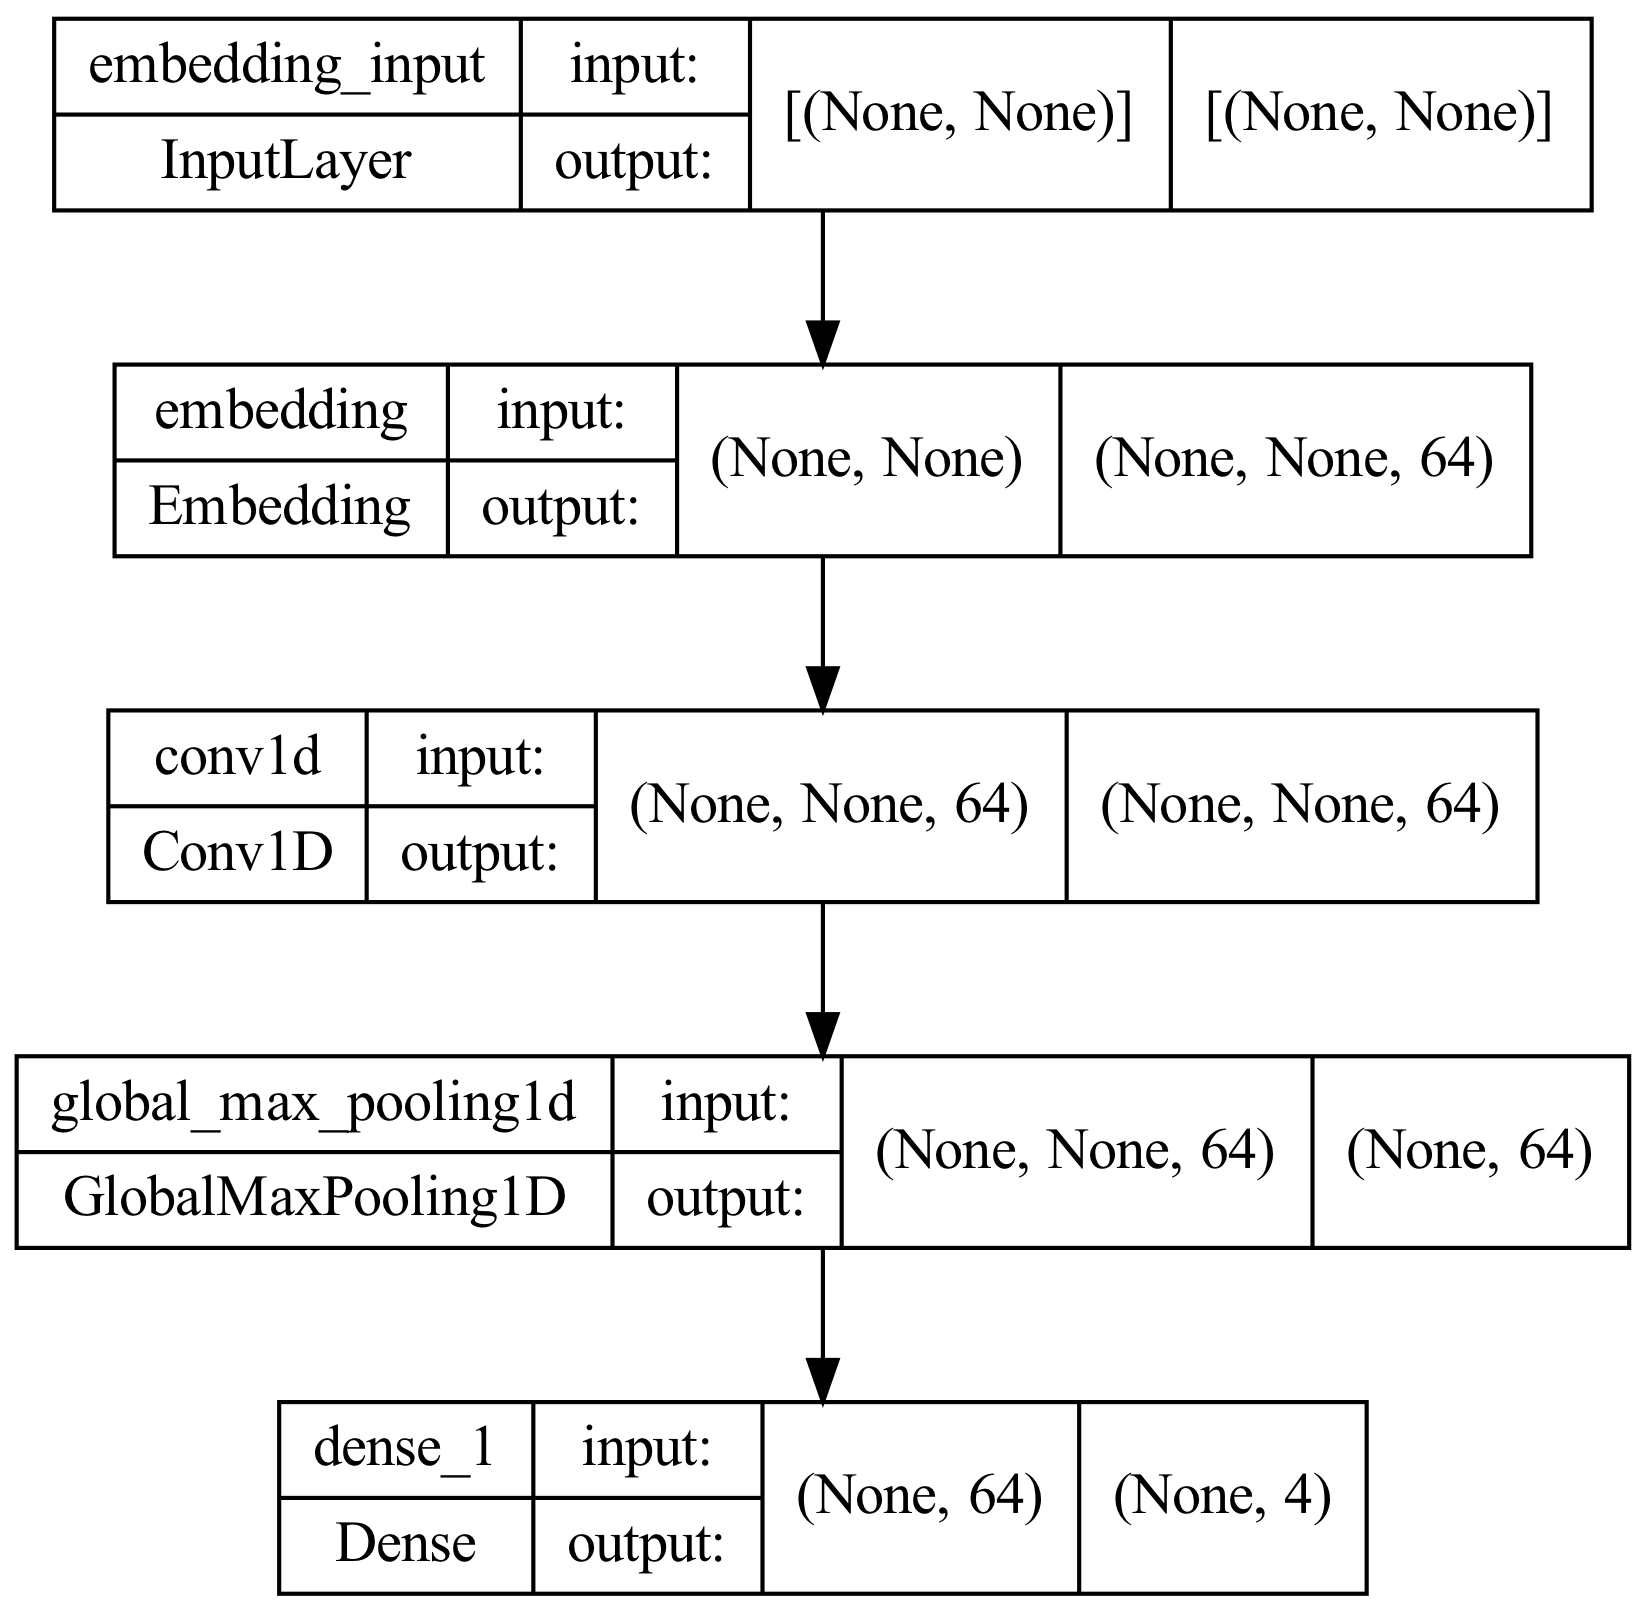

In [34]:
plot_model(int_model, show_shapes=True, dpi=300)

In [35]:
histroy = int_model.fit(int_train_ds, validation_data=int_val_ds, epochs=5)

Epoch 1/5
  3/200 [..............................] - ETA: 4s - loss: 1.3808 - accuracy: 0.2812 

2022-08-21 09:07:07.700039: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


200/200 [==============================] - ETA: 0s - loss: 1.1450 - accuracy: 0.5128

2022-08-21 09:07:12.633129: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


200/200 [==============================] - 5s 25ms/step - loss: 1.1450 - accuracy: 0.5128 - val_loss: 0.7672 - val_accuracy: 0.6787
Epoch 2/5
200/200 [==============================] - 5s 25ms/step - loss: 0.6249 - accuracy: 0.7573 - val_loss: 0.5430 - val_accuracy: 0.7875
Epoch 3/5
200/200 [==============================] - 5s 25ms/step - loss: 0.3765 - accuracy: 0.8856 - val_loss: 0.4713 - val_accuracy: 0.8125
Epoch 4/5
200/200 [==============================] - 5s 25ms/step - loss: 0.2092 - accuracy: 0.9511 - val_loss: 0.4674 - val_accuracy: 0.8194
Epoch 5/5
200/200 [==============================] - 5s 25ms/step - loss: 0.1060 - accuracy: 0.9814 - val_loss: 0.4895 - val_accuracy: 0.8206


In [36]:
binary_loss, binary_accuracy = binary_model.evaluate(binary_test_ds)
int_loss, int_accuracy = int_model.evaluate(int_test_ds)

250/250 [==============================] - 1s 5ms/step - loss: 0.5048 - accuracy: 0.8121


In [37]:
print("binary accuracy: {:2.2%}".format(binary_accuracy))
print('int_accuracy: {:2.2%}'.format(int_accuracy))

binary accuracy: 81.50%
int_accuracy: 81.21%


### Export the model

In [38]:
binary_model2 = tf.keras.Sequential([layers.Dense(4)])

export_model = tf.keras.Sequential([
    binary_vectorize_layer, binary_model, layers.Activation('sigmoid')
])

export_model.compile(loss=losses.SparseCategoricalCrossentropy(from_logits=False),
                    optimizer='adam',
                    metrics=['accuracy'])

loss, accuracy = export_model.evaluate(raw_test_ds)
print("Accuracy: {:2.2%}".format(accuracy))

 16/250 [>.............................] - ETA: 1s - loss: 0.5164 - accuracy: 0.7949

2022-08-21 09:07:35.358553: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


250/250 [==============================] - 2s 7ms/step - loss: 0.5180 - accuracy: 0.8150
Accuracy: 81.50%


In [39]:
def get_string_labels(predicted_scores_batch):
    predicted_int_labels = tf.math.argmax(predicted_scores_batch, axis=1)
    predicted_labels = tf.gather(raw_train_ds.class_names, predicted_int_labels)

    return predicted_labels

### Run inference on new data

In [40]:
inputs = [
    "how do I extract keys from a dict into a list?",  # 'python'
    "debug public static void main(string[] args) {...}",  # 'java'
]

In [41]:
predicted_scores = export_model.predict(inputs)
predicted_labels = get_string_labels(predicted_scores)
print(predicted_scores)
print(predicted_labels)

[[0.37885544 0.25547436 0.21967159 0.8081621 ]
 [0.70447934 0.7908031  0.08547339 0.09343835]]
tf.Tensor([b'python' b'java'], shape=(2,), dtype=string)


2022-08-21 09:07:37.344550: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


## Example 2: Predict the author of Iliad translations

In [42]:
DIRECTORY_URL = 'https://storage.googleapis.com/download.tensorflow.org/data/illiad/'
FILE_NAMES = ['cowper.txt', 'derby.txt', 'butler.txt']

In [43]:
path = '/Users/rainyseason/winston/Workspace/python/Pycharm Project/tf25/iliad/'

In [44]:
for name in FILE_NAMES:
    text_dir = utils.get_file(name, origin=DIRECTORY_URL + name,
                              cache_subdir=path,
                              cache_dir=path+'cache')

In [45]:
parent_dir = pathlib.Path(text_dir).parent

In [46]:
list(parent_dir.iterdir())

[PosixPath('/Users/rainyseason/winston/Workspace/python/Pycharm Project/tf25/iliad/cowper.txt'),
 PosixPath('/Users/rainyseason/winston/Workspace/python/Pycharm Project/tf25/iliad/.DS_Store'),
 PosixPath('/Users/rainyseason/winston/Workspace/python/Pycharm Project/tf25/iliad/butler.txt'),
 PosixPath('/Users/rainyseason/winston/Workspace/python/Pycharm Project/tf25/iliad/derby.txt')]

### Load the dataset

Previously, with tf.keras.utils.text_dataset_from_directory all contents of a file were treated as a single example. Here, you will use tf.data.TextLineDataset, which is designed to create a tf.data.Dataset from a text file where each example is a line of text from the original file. TextLineDataset is useful for text data that is primarily line-based (for example, poetry or error logs).

Iterate through these files, loading each one into its own dataset. Each example needs to be individually labeled, so use Dataset.map to apply a labeler function to each one. This will iterate over every example in the dataset, returning (example, label) pairs.

In [47]:
def labeler(example, index):
    return example, tf.cast(index, tf.int64)

In [48]:
labeled_data_sets = []

for i, file_name in enumerate(FILE_NAMES):
    lines_dataset = tf.data.TextLineDataset(str(parent_dir / file_name))
    labeled_dataset = lines_dataset.map(lambda ex: labeler(ex, i))
    labeled_data_sets.append(labeled_dataset)

In [49]:
BUFFER_SIZE = 50000
BATCH_SIZE = 64
VALIDATION_SIZE = 5000

In [50]:
all_labeled_data = labeled_data_sets[0]
for labeled_dataset in labeled_data_sets[1:]:
    all_labeled_data = all_labeled_data.concatenate(labeled_dataset)

In [51]:
for text, label in all_labeled_data.take(5):
    print(text.numpy())
    print(label.numpy())

b"\xef\xbb\xbfAchilles sing, O Goddess! Peleus' son;"
0
b'His wrath pernicious, who ten thousand woes'
0
b"Caused to Achaia's host, sent many a soul"
0
b'Illustrious into Ades premature,'
0
b'And Heroes gave (so stood the will of Jove)'
0


In [52]:
len(list(all_labeled_data.map(lambda x, y: y)))

49608

In [53]:
all_labeled_data = all_labeled_data.shuffle(BUFFER_SIZE, reshuffle_each_iteration=False)

In [54]:
for text, label in all_labeled_data.take(3):
    print(f"Sentense: {text.numpy()}")
    print(f"Label: {label.numpy()}")

Sentense: b"Thus pray'd he; Jove, the Lord of counsel, heard,"
Label: 1
Sentense: b'Iphitus the son of Naubolus. These were they that held Cyparissus,'
Label: 2
Sentense: b'them. Nestor knight of Gerene was first to question them. "Tell me,"'
Label: 2


### Prepare the dataset for training

In [55]:
tokenizer = tf_text.UnicodeScriptTokenizer()

In [56]:
def tokenize(text, unused_label):
    lower_case = tf_text.case_fold_utf8(text)
    # # under "tokenize" is not def tokenize, but is "UnicodeScriptTokenizer().tokenize"
    return tokenizer.tokenize(lower_case)

In [57]:
tokenized_ds = all_labeled_data.map(tokenize)

In [58]:
for text_token in tokenized_ds.take(3):
    print(text_token.numpy())

[b'thus' b'pray' b"'" b'd' b'he' b';' b'jove' b',' b'the' b'lord' b'of'
 b'counsel' b',' b'heard' b',']
[b'iphitus' b'the' b'son' b'of' b'naubolus' b'.' b'these' b'were' b'they'
 b'that' b'held' b'cyparissus' b',']
[b'them' b'.' b'nestor' b'knight' b'of' b'gerene' b'was' b'first' b'to'
 b'question' b'them' b'."' b'tell' b'me' b',"']


Next, you will build a vocabulary by sorting tokens by frequency and keeping the top VOCAB_SIZE tokens:

In [59]:
tokenized_ds = configure_dataset(tokenized_ds)

In [118]:
vocab_dict = collections.defaultdict(lambda: 0)
for toks in tokenized_ds.as_numpy_iterator():
    for tok in toks:
        vocab_dict[tok] += 1

temp = 0
for tok, count in vocab_dict.items():
    if temp == 5:
        break
    print(tok, count)
    temp += 1

b'thus' 1557
b'pray' 164
b"'" 15695
b'd' 8802
b'he' 7004


In [121]:
vocab = sorted(vocab_dict.items(), key=lambda x: x[1], reverse=True) # # return list type
vocab[:5]

[(b',', 45478),
 (b'the', 28299),
 (b'and', 17012),
 (b"'", 15695),
 (b'of', 13489)]

In [122]:
vocab = [token for token, count in vocab] # # count is not needed to training
vocab[:5]

[b',', b'the', b'and', b"'", b'of']

In [244]:
vocab = vocab[:VOCAB_SIZE]
vocab_size = len(vocab)
print(f"Vocab size: {len(vocab)}")
print(f"First five vocab entries: {vocab[:5]}")

Vocab size: 10000
First five vocab entries: [b',', b'the', b'and', b"'", b'of']


To convert the tokens into integers, use the vocab set to create a tf.lookup.StaticVocabularyTable. You will map tokens to integers in the range [2, vocab_size + 2]. As with the TextVectorization layer, 0 is reserved to denote padding and 1 is reserved to denote an out-of-vocabulary (OOV) token.

In [128]:
keys = vocab
values = range(2, len(vocab) + 2) # # Reserve '0' for padding, '1' for ODV tokens.

init = tf.lookup.KeyValueTensorInitializer(keys,
                                          values,
                                          key_dtype=tf.string,
                                          value_dtype=tf.int64)
num_odv_buckets = 1
vocab_table = tf.lookup.StaticVocabularyTable(init, num_odv_buckets)

Finally, define a function to standardize, tokenize and vectorize the dataset using the tokenizer and lookup table:

In [129]:
def preprocess_text(text, label):
    standardized = tf_text.case_fold_utf8(text)
    tokenized = tokenizer.tokenize(standardized)
    vectorized = vocab_table.lookup(tokenized)
    return vectorized, label

You can try this on a single example to print the output:

In [137]:
example_text, example_label = next(iter(all_labeled_data))
print("Sentence: ", example_text.numpy())
print("Vectorized sentence: ", preprocess_text(example_text, example_label))

Sentence:  b"Thus pray'd he; Jove, the Lord of counsel, heard,"
Vectorized sentence:  (<tf.Tensor: shape=(15,), dtype=int64, numpy=
array([ 45, 390,   5,   9,  12,  10,  53,   2,   3, 425,   6, 377,   2,
       253,   2])>, <tf.Tensor: shape=(), dtype=int64, numpy=1>)


Now run the preprocess function on the dataset using Dataset.map:

In [138]:
all_encoded_data = all_labeled_data.map(preprocess_text)

In [166]:
for i in all_encoded_data.take(3):
    print(len(i[0].numpy()), end='     ')
    print(i[0].numpy())

15     [ 45 390   5   9  12  10  53   2   3 425   6 377   2 253   2]
13     [3768    3   28    6 7806    7  106   61   27   23  282 5605    2]
15     [  39    7  239 1464    6 2384   36  108    8 2097   39   52  439   40
   77]


### Split the dataset into training and test sets

tf.data.Dataset supports splitting and padded-batching datasets:

In [167]:
train_data = all_encoded_data.skip(VALIDATION_SIZE).shuffle(BUFFER_SIZE)
validation_data = all_encoded_data.take(VALIDATION_SIZE)

In [168]:
# # check the role of padded_batch()
train_data = train_data.padded_batch(BATCH_SIZE)
validation_data = validation_data.padded_batch(BATCH_SIZE)

In [175]:
temp = iter(validation_data)

In [241]:
sample_text, sample_labels = next(temp)
print("Text batch shape: ", sample_text.shape)
print("Label batch shape: ", sample_labels.shape)
print("First text example: ", sample_text[0])
print("First label example: ", sample_labels[0])

Text batch shape:  (64, 19)
Label batch shape:  (64,)
First text example:  tf.Tensor(
[  93   95  144    2 1019   17 1977    2  409   17 1564  115    2    0
    0    0    0    0    0], shape=(19,), dtype=int64)
First label example:  tf.Tensor(1, shape=(), dtype=int64)


Since you use 0 for padding and 1 for out-of-vocabulary (OOV) tokens, the vocabulary size has increased by two:

In [246]:
vocab_size += 2

In [247]:
train_data = configure_dataset(train_data)
validation_data = configure_dataset(validation_data)

### Train the model

In [249]:
model = create_model(vocab_size=vocab_size, num_labels=3)

model.compile(optimizer='adam',
             loss=losses.SparseCategoricalCrossentropy(from_logits=True),
             metrics=['accuracy'])

histroy = model.fit(train_data, validation_data=validation_data, epochs=3)

Epoch 1/3


2022-08-21 11:05:50.846799: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-08-21 11:06:00.872376: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 40058 of 50000
2022-08-21 11:06:01.839854: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


    693/Unknown - 18s 10ms/step - loss: 0.5170 - accuracy: 0.7724

2022-08-21 11:06:09.591687: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


697/697 [==============================] - 20s 13ms/step - loss: 0.5164 - accuracy: 0.7725 - val_loss: 0.3672 - val_accuracy: 0.8468
Epoch 2/3
697/697 [==============================] - 7s 9ms/step - loss: 0.2852 - accuracy: 0.8865 - val_loss: 0.3522 - val_accuracy: 0.8534
Epoch 3/3
697/697 [==============================] - 6s 9ms/step - loss: 0.1945 - accuracy: 0.9262 - val_loss: 0.3854 - val_accuracy: 0.8516


In [251]:
loss, accuracy = model.evaluate(validation_data)

print(f"loss:     {loss}")
print(f"accuracy: {accuracy:2.2%}")

79/79 [==============================] - 1s 4ms/step - loss: 0.3854 - accuracy: 0.8516
loss:     0.38535428047180176
accuracy: 85.16%


### Export the model

To make the model capable of taking raw strings as input, you will create a Keras TextVectorization layer that performs the same steps as your custom preprocessing function. Since you have already trained a vocabulary, you can use TextVectorization.set_vocabulary (instead of TextVectorization.adapt), which trains a new vocabulary.

In [252]:
preprocess_layer = TextVectorization(max_tokens=vocab_size,
                                    standardize=tf_text.case_fold_utf8,
                                     split=tokenizer.tokenize,
                                     output_mode='int',
                                     output_sequence_length=MAX_SEQUENCE_LENGTH)

In [256]:
preprocess_layer.set_vocabulary(vocab)

In [301]:
export_model = tf.keras.Sequential([preprocess_layer,
                                  model,
                                  layers.Activation('softmax')])

export_model.compile(loss=losses.SparseCategoricalCrossentropy(from_logits=True),
                     optimizer='adam',
                     metrics=['accuracy'])

In [302]:
# Create a test dataset of raw strings
test_ds = all_labeled_data.take(VALIDATION_SIZE).batch(BATCH_SIZE)
test_ds = configure_dataset(test_ds)

loss, accuracy = export_model.evaluate(test_ds)

print(f"Loss: {loss}")
print(f"Accuracy: {accuracy:2.2%}")

/Users/rainyseason/miniforge3/envs/tf25/lib/python3.8/site-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)
2022-08-21 16:00:32.242543: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-08-21 16:00:32.303988: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: sequential_7/text_vectorization_2/UnicodeScriptTokenize/Assert/AssertGuard/branch_executed/_175


79/79 [==============================] - 4s 16ms/step - loss: 0.4787 - accuracy: 0.8094
Loss: 0.4787091016769409
Accuracy: 80.94%


### Run inference on new data

In [281]:
inputs = [
    "Join'd to th' Ionians with their flowing robes,",  # Label: 1
    "the allies, and his armour flashed about him so that he seemed to all",  # Label: 2
    "And with loud clangor of his arms he fell.",  # Label: 0
]

In [285]:
predicted_scores = export_model.predict(inputs)
predicted_labels = tf.math.argmax(predicted_scores, axis=1)

In [288]:
for input, label in zip(inputs, predicted_labels):
    print(f"Question:        {input}")
    print(f"Predicted Label: {label}")

Question:        Join'd to th' Ionians with their flowing robes,
Predicted Label: 1
Question:        the allies, and his armour flashed about him so that he seemed to all
Predicted Label: 2
Question:        And with loud clangor of his arms he fell.
Predicted Label: 0


## Download more datasets using TensorFlow Datasets (TFDS)

You can download many more datasets from TensorFlow Datasets.

In this example, you will use the IMDB Large Movie Review dataset to train a model for sentiment classification:

In [320]:
# Training set.
train_ds = tfds.load(
    'imdb_reviews',
    split='train[:80%]',
    batch_size=BATCH_SIZE,
    shuffle_files=True,
    as_supervised=True)

In [321]:
# Validation set.
val_ds = tfds.load(
    'imdb_reviews',
    split='train[80%:]',
    batch_size=BATCH_SIZE,
    shuffle_files=True,
    as_supervised=True)

In [322]:
for review_batch, label_batch in val_ds.take(1):
    for i in range(2):
        print("Review: {}".format(review_batch[i].numpy()))
        print("Label: {}".format(label_batch[i].numpy()))

Review: b"Instead, go to the zoo, buy some peanuts and feed 'em to the monkeys. Monkeys are funny. People with amnesia who don't say much, just sit there with vacant eyes are not all that funny.<br /><br />Black comedy? There isn't a black person in it, and there isn't one funny thing in it either.<br /><br />Walmart buys these things up somehow and puts them on their dollar rack. It's labeled Unrated. I think they took out the topless scene. They may have taken out other stuff too, who knows? All we know is that whatever they took out, isn't there any more.<br /><br />The acting seemed OK to me. There's a lot of unfathomables tho. It's supposed to be a city? It's supposed to be a big lake? If it's so hot in the church people are fanning themselves, why are they all wearing coats?"
Label: 0
Review: b'Well, was Morgan Freeman any more unusual as God than George Burns? This film sure was better than that bore, "Oh, God". I was totally engrossed and LMAO all the way through. Carrey was pe

2022-08-21 16:16:38.506289: W tensorflow/core/kernels/data/cache_dataset_ops.cc:768] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


### Prepare the dataset for training

In [323]:
vectorize_layer = TextVectorization(max_tokens=VOCAB_SIZE,
                                   output_mode='int',
                                   output_sequence_length=MAX_SEQUENCE_LENGTH)

# Make a text-only dataset (without labels), then call `TextVectorization.adapt`.
train_text = train_ds.map(lambda x, y: x)
vectorize_layer.adapt(train_text)

2022-08-21 16:16:38.885700: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


In [324]:
def vectorize_text(text, label):
    text = tf.expand_dims(text, -1)
    return vectorize_layer(text), label

In [325]:
train_ds = train_ds.map(vectorize_text)
val_ds = val_ds.map(vectorize_text)

In [326]:
train_ds = configure_dataset(train_ds)
val_ds = configure_dataset(val_ds)

### Create, configure and train the model

In [328]:
model = create_model(vocab_size=VOCAB_SIZE + 1, num_labels=1)

In [329]:
model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, None, 64)          640064    
                                                                 
 conv1d_3 (Conv1D)           (None, None, 64)          20544     
                                                                 
 global_max_pooling1d_3 (Glo  (None, 64)               0         
 balMaxPooling1D)                                                
                                                                 
 dense_5 (Dense)             (None, 1)                 65        
                                                                 
Total params: 660,673
Trainable params: 660,673
Non-trainable params: 0
_________________________________________________________________


In [331]:
model.compile(loss=losses.BinaryCrossentropy(from_logits=True),
             optimizer='adam',
             metrics=['accuracy'])

history = model.fit(train_ds, validation_data=val_ds, epochs=3)

Epoch 1/3


2022-08-21 16:20:41.187257: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


313/313 [==============================] - ETA: 0s - loss: 0.5407 - accuracy: 0.6654

2022-08-21 16:20:48.100337: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


313/313 [==============================] - 8s 22ms/step - loss: 0.5407 - accuracy: 0.6654 - val_loss: 0.3742 - val_accuracy: 0.8278
Epoch 2/3
313/313 [==============================] - 4s 13ms/step - loss: 0.3004 - accuracy: 0.8686 - val_loss: 0.3143 - val_accuracy: 0.8578
Epoch 3/3
313/313 [==============================] - 4s 13ms/step - loss: 0.1844 - accuracy: 0.9282 - val_loss: 0.3237 - val_accuracy: 0.8600


In [333]:
loss, accuracy = model.evaluate(val_ds)
print("Loss: ", loss)
print("Accuracy: {:2.2%}".format(accuracy))

79/79 [==============================] - 0s 5ms/step - loss: 0.3237 - accuracy: 0.8600
Loss:  0.3236521780490875
Accuracy: 86.00%


### Export the model

In [334]:
export_model = tf.keras.Sequential([vectorize_layer,
                                   model,
                                    layers.Activation('sigmoid')])

export_model.compile(loss=losses.BinaryCrossentropy(from_logits=True),
                    optimizer='adam',
                    metrics=['accuracy'])

In [357]:
# 0 --> negative review
# 1 --> positive review
inputs = [
    "This is a fantastic movie.",
    "This is a bad movie.",
    "This movie was so bad that it was good.",
    "I will never say yes to watching this movie.",
    "Will I ever see this movie again?", 
    "Why is the time to watch this movie wasted?"
]

In [358]:
predicted_scores = export_model.predict(inputs)
predicted_scores

array([[9.9879295e-01],
       [6.5448575e-02],
       [2.4162711e-01],
       [4.0174028e-01],
       [9.1728133e-01],
       [8.0496364e-04]], dtype=float32)

In [359]:
predicted_labels = [round(x[0]) for x in predicted_scores]

In [361]:
for input, label in zip(inputs, predicted_labels):
    print("Question: ", input)
    print("Predicted label: ", label)

Question:  This is a fantastic movie.
Predicted label:  1
Question:  This is a bad movie.
Predicted label:  0
Question:  This movie was so bad that it was good.
Predicted label:  0
Question:  I will never say yes to watching this movie.
Predicted label:  0
Question:  Will I ever see this movie again?
Predicted label:  1
Question:  Why is the time to watch this movie wasted?
Predicted label:  0
